Here we seek to solve
\begin{align}
\min_{(u,\rho)\in\mathcal{V}\times\mathcal{M}}J(u,\rho)&:=\frac{1}{2}\int_{\Omega}(u-u_{d})^{2}\mathrm{d}V+\frac{1}{2}R(\rho)\\
R(\rho)&:=\int_{\Omega}(\gamma_{1}\,\rho^{2}+\gamma_{2}\nabla \rho\cdot\nabla \rho)\mathrm{d}V
\end{align}

subject to the partial differential equality constraint

\begin{align*}
-\Delta u+\beta\, u&=\rho,\,\,\,\text{ in }\Omega \\
\frac{\partial u}{\partial n}&=0,\,\,\,\text{ on }\partial\Omega
\end{align*}

and bound constraint

\begin{align*}
\rho(x)\geq \rho_{\ell}(x)>0,\,\,\,\text{ on }\overline{\Omega}
\end{align*}

here $\beta\in\mathbb{R}$, $f:\Omega\rightarrow\mathbb{R}$, $u_{d}:\Omega\rightarrow\mathbb{R}$, $\rho_{\ell}:\overline{\Omega}\rightarrow\mathbb{R}_{>0}$, $\lbrace \gamma_{j}\rbrace_{j=1}^{2}\subset\mathbb{R}_{\geq 0}$ are given.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False


from filterLineSearch import interior_pt
from hippylib import nb


In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

In [3]:
def csr_fenics2scipy(A_fenics):
    ai, aj, av = dl.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

In [4]:
"""
An object which will internally handle the finite-element
discretization of the infinite-dimensional inverse problem
and set up the linear KKT system.
"""    

class inverseRHS:
    def __init__(me, Vh, Vh1, Vh2, beta, gamma1, gamma2, ud, rhol):
        
        me.Vh    = Vh
        me.Vh1   = Vh1
        me.Vh2   = Vh2
        me.rhol  = rhol
        
        # n1 dofs for state
        # n2 dofs for parameter
        me.n1    = me.Vh.sub(0).dim()
        me.n2    = me.Vh.sub(1).dim()
        me.n     = me.n1 + me.n2
        me.m     = me.n1
        
        # data that we are fitting the model to
        me.ud    = ud

              
        me.beta   = beta
        me.gamma1 = gamma1
        me.gamma2 = gamma2
        utest,  mtest = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        Rform = (dl.Constant(gamma1) * mtest * mtrial +\
                 dl.Constant(gamma2) * dl.inner(dl.grad(mtest), dl.grad(mtrial))) * dl.dx(me.Vh.mesh())
        Mform = (utest * utrial + mtest * mtrial) * dl.dx(me.Vh.mesh())
       
        me.R_fenics  = dl.assemble(Rform)
        me.R         = me.R_fenics.array()[me.n1:, me.n1:]
        me.M_fenics  = dl.assemble(Mform)
        me.Mx        = me.M_fenics.array()
        me.Mu        = me.Mx[:me.n1,:me.n1]
        me.Mm        = me.Mx[me.n1:,me.n1:]

    """
    In what follows x will be a function on the state-parameter product
    finite-element space
    """
    
    """
    objective -- return the value of the regularized data-misfit functional at x
    """
    def f(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        return dl.assemble((dl.Constant(0.5) * (X.sub(0)-me.ud)**2. + \
                           dl.Constant(me.gamma1/2.)*X.sub(1)*X.sub(1) + \
                           dl.Constant(me.gamma2/2.)*dl.inner(\
                           dl.grad(X.sub(1)), dl.grad(X.sub(1))))*dl.dx(me.Vh.mesh()))
    """
    gradient -- return the variational derivative of J with respect to x
    """
    def Dxf(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        utest, rhotest = dl.TestFunctions(me.Vh)
        return dl.assemble(((X.sub(0) - me.ud) * utest + \
                            dl.Constant(me.gamma1) * X.sub(1) * rhotest + \
                            dl.Constant(me.gamma2) * \
                            dl.inner(dl.grad(X.sub(1)), dl.grad(rhotest)))*dl.dx(me.Vh.mesh())).get_local()
    def Dxxfform(me, x):
        utest, mtest = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return (utrial*utest + \
                                dl.Constant(me.gamma1)*\
                                mtrial*mtest + \
                                dl.Constant(me.gamma2)*\
                                dl.inner(dl.grad(mtest), dl.grad(mtrial)))*dl.dx(me.Vh.mesh())
    """ 
    return the second variational derivative of J with respect to x, that is 
    a linear mapping from primal to dual 
    """
    def Dxxf(me, x):
        return dl.assemble(me.Dxxfform(x)).array()
    """
    constraints -- evaluate the PDE-constraint at x, returning a dual-vector 
    """    
    def c(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        utest, mtest = dl.TestFunctions(me.Vh)
        return dl.assemble((dl.inner(dl.grad(X.sub(0)), dl.grad(utest)) + \
                            dl.Constant(me.beta)*X.sub(0)*utest - X.sub(1)*utest)*dl.dx(me.Vh.mesh()))\
                            .get_local()[:me.n1]
    def theta(me, x):
        return np.linalg.norm(me.c(x), 2)
    """
    evaluate the variational derivative of the PDE-constraint with respect
    to x, 
    return a linear mapping from the primal to the dual
    """
    def Dxc(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        p, _   = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        J = csr_fenics2scipy(\
                  dl.assemble((dl.inner(dl.grad(utrial), dl.grad(p)) + \
                                dl.Constant(me.beta)*utrial*p - mtrial*p)*\
                               dl.dx(me.Vh.mesh()))).todense()
        J = np.array(J[:me.n1,:])
        return J
    # constraint Jacobian
    def Dxxcpform(me, x, p):
        X = dl.Function(me.Vh)
        P = dl.Function(me.Vh)
        P.vector().vec()[:me.n1] = p[:]
        X.vector().set_local(x)
        utest, mtest   = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return (dl.Constant(0.0)*(mtest * utrial + mtrial * utest))*\
                                            dl.dx(me.Vh.mesh())
    def Dxxcp(me, x, p):
        return dl.assemble(me.Dxxcpform(x, p))
    def phi(me, x, mu):
        return me.f(x) - mu * sum(np.log(x[me.n1:] - me.rhol))
    def Dxphi(me, x, mu):
        y = np.zeros(me.n)
        y += me.Dxf(x)
        y[me.n1:] += -mu / (x[me.n1:] - me.rhol)
        return y
    def L(me, X):
        x, lam, z = X[:]
        return (me.f(x) + np.inner(lam, me.c(x)) - np.inner(z, x[me.n1:]-me.rhol))
    def DxL(me, X):
        x, lam, z = X[:]
        y = np.zeros(me.n)
        y = me.Dxf(x) + np.dot(lam.T, me.Dxc(x))
        y[me.n1:] -= z[:]
        return y
    def DxxL(me, X):
        x, lam, z = X[:]
        y = np.zeros((me.n, me.n))
        y[:, :] += me.Dxxf(x)
        #y[:, :] += me.Dxxcp(x, lam).array()[:,:]
        return y
    def E(me, X, mu, smax):
        x, lam, z = X[:]
        rho = x[me.n1:]
        E1 = np.linalg.norm(me.DxL(X), np.inf)
        E3 = np.linalg.norm((rho - me.rhol)*z-mu, np.inf)
        laml1 = np.linalg.norm(lam, 1)
        zl1   = np.linalg.norm(z,   1)
        sd    = max(smax, (laml1 + zl1) / (me.m + me.n)) / smax
        sc    = max(smax, zl1 / me.n) / smax
        E2    = np.linalg.norm(me.c(x), np.inf)
        return max(E1 / sd, E2, E3 / sc), E1, E2, E3
    def restore_feasibility(me, x):
        u = x[:me.n1]
        rho = x[me.n1:]
        utest  = dl.TestFunction(me.Vh2)
        utrial = dl.TrialFunction(me.Vh2)
        rhofunc = dl.Function(me.Vh1)
        rhofunc.vector()[:] = rho[:]
        aform = (dl.inner(dl.grad(utest), dl.grad(utrial)) + me.beta * utest * utrial) * dl.dx(me.Vh2.mesh())
        Lform = rhofunc * utest * dl.dx(me.Vh2.mesh())
        usol  = dl.Function(me.Vh2)
        A, b  = dl.assemble_system(aform, Lform, [])
        dl.solve(A, usol.vector(), b)
        return usol.vector()[:]

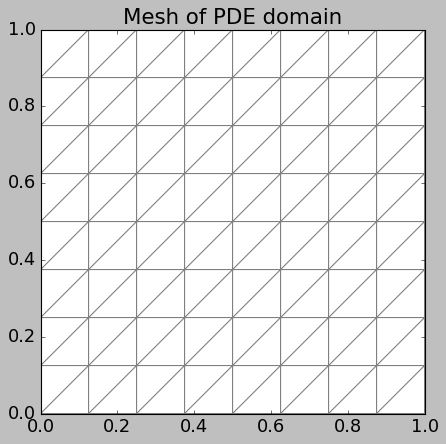

In [5]:
nx = 8 
    
mesh = dl.UnitSquareMesh(nx, nx)
dl.plot(mesh)
plt.title('Mesh of PDE domain')
plt.show()

In [6]:
P1 = dl.FiniteElement("CG", mesh.ufl_cell(), 1)
P2 = dl.FiniteElement("CG", mesh.ufl_cell(), 2)
Th = dl.MixedElement([P2, P1])
Vh = dl.FunctionSpace(mesh, Th)
Vh1 = dl.FunctionSpace(mesh, P1)
Vh2 = dl.FunctionSpace(mesh, P2)
print("dim(state) = {0:d}, dim(parameter) = {1:d}".format(Vh2.dim(), Vh1.dim()))

dim(state) = 81, dim(parameter) = 384


In [7]:
beta   = 1.e-4
gamma1  = 1.e-4
gamma2 = 1.e-4
Crhol  = -10.
rhol  = dl.interpolate(dl.Expression('C', element=Vh1.ufl_element(), C=Crhol), Vh1).vector().get_local()
ud    = dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                          pi=np.pi, element=Vh2.ufl_element()), Vh2)
   
rhotrue = dl.interpolate(dl.Expression('C*std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                      element=Vh1.ufl_element(), C= (beta+2.*np.pi**2), pi=np.pi), Vh1)
    
    
# initial point
x0 = np.array([1.+np.random.randn() if i < Vh2.dim() \
      else (abs(np.random.randn())+1. + rhol[i-Vh2.dim()]) for i in range(Vh.dim())])
    
problem = inverseDiffusion(Vh, Vh1, Vh2, beta, gamma1, gamma2, ud, rhol)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.


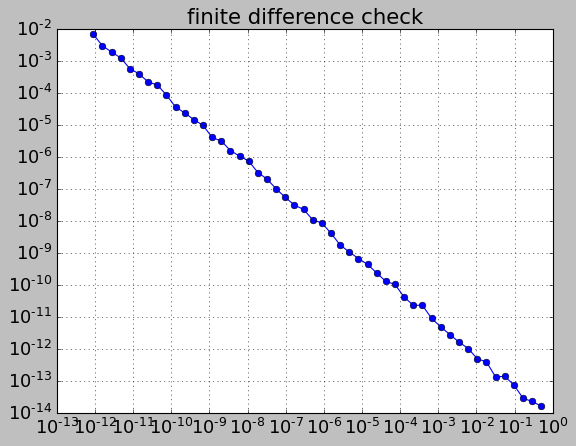

In [8]:
# ---- gradient check

epss  = np.logspace(1, 40, base=0.5)
     
F     = lambda x : problem.c(x)
gradF = lambda x : problem.Dxc(x)
F0   = F(x0)
gradF0   = gradF(x0)
xhat = np.random.randn(problem.n)
grad_err = np.zeros(len(epss))
for j, eps in enumerate(epss):
    Fplus = F(x0 + eps*xhat)
    if len(gradF0.shape) > 1:
        grad_err[j] = np.linalg.norm((Fplus - F0)/ eps - np.dot(gradF0, xhat), 2)
    else:
        grad_err[j] = np.abs((Fplus - F0) / eps - np.inner(gradF0, xhat))
plt.plot(epss, grad_err, '-ob')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('finite difference check')
plt.show()


In [9]:
solver = interior_pt(problem)
x0      = np.ones(problem.n)
x0[:problem.n1] = problem.restore_feasibility(x0)
X0      = [x0, np.ones(problem.m), np.ones(problem.n2)]
solver.initialize(X0)
mu0 = 1.e0
tol = 1.e-10
max_it = 30
Xf, mu, E, Mus = solver.solve(tol, max_it, mu0)
xf, lamf, zf = Xf[:]

-------------------------------------------------- it = 0
Calling FFC just-in-time (JIT) compiler, this may take some time.
-------------------------------------------------- determining search direction 
Calling FFC just-in-time (JIT) compiler, this may take some time.
KKT sys error = 5.173e-14
inertia of IP-Newton system matrix = (465, 81, 0)
inertia (to guarantee descent near feasible points) = (465, 81, 0)
smallest eigenvalue by magnitude = 3.52e-04
cond(Wk(delta=0)) = 8.55e+01
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 9.776e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.
in filter region?  False
A.5.4
theta(x) = 4.02e-11
angle between xhat and Dxphi = 161.4 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 1
solved barrier problem (mu = 1.000e+00)
solved barrier problem (mu = 5.0

in filter region?  False
A.5.4
theta(x) = 7.45e-16
angle between xhat and Dxphi = 90.1 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 12
-------------------------------------------------- determining search direction 
KKT sys error = 5.532e-14
inertia of IP-Newton system matrix = (465, 81, 0)
inertia (to guarantee descent near feasible points) = (465, 81, 0)
smallest eigenvalue by magnitude = 2.60e-07
cond(Wk(delta=0)) = 1.31e+05
NO INERTIA CORRECTION WAS REQUIRED
alpha = 9.522e-01, alphaz = 9.545e-01
in filter region?  False
A.5.4
theta(x) = 6.79e-16
angle between xhat and Dxphi = 90.0 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 13
--------------------------

step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 18
solved barrier problem (mu = 5.167e-11)
-------------------------------------------------- determining search direction 
KKT sys error = 1.319e-16
inertia of IP-Newton system matrix = (465, 81, 0)
inertia (to guarantee descent near feasible points) = (465, 81, 0)
smallest eigenvalue by magnitude = 2.60e-07
cond(Wk(delta=0)) = 2.30e+07
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 1.000e+00
in filter region?  False
A.5.4
theta(x) = 8.04e-16
angle between xhat and Dxphi = 90.0 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE II
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 19
solved interior point problem


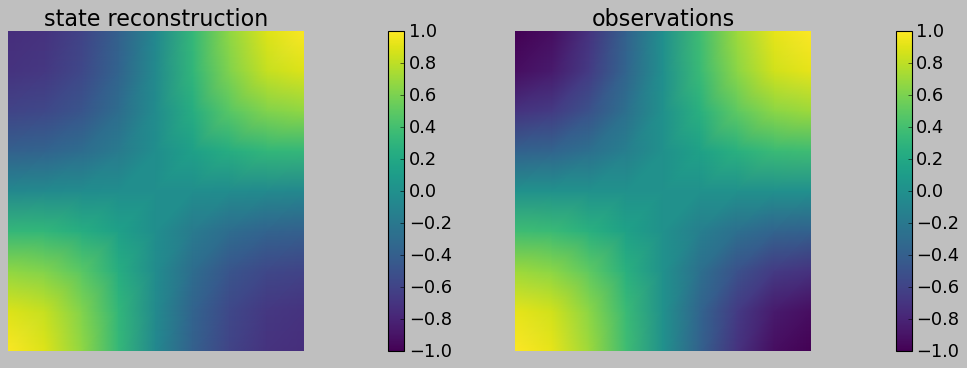

In [10]:
uReconstruction   = dl.Function(Vh2)
lamReconstruction = dl.Function(Vh2)

rhoReconstruction = dl.Function(Vh1)
zReconstruction   = dl.Function(Vh1)

uReconstruction.vector()[:]   = xf[:problem.n1]
rhoReconstruction.vector()[:] = xf[problem.n1:]

lamReconstruction.vector()[:] = lamf[:]
zReconstruction.vector()[:]   = zf[:]

nb.multi1_plot([uReconstruction, ud], ["state reconstruction", "observations"])
plt.show()

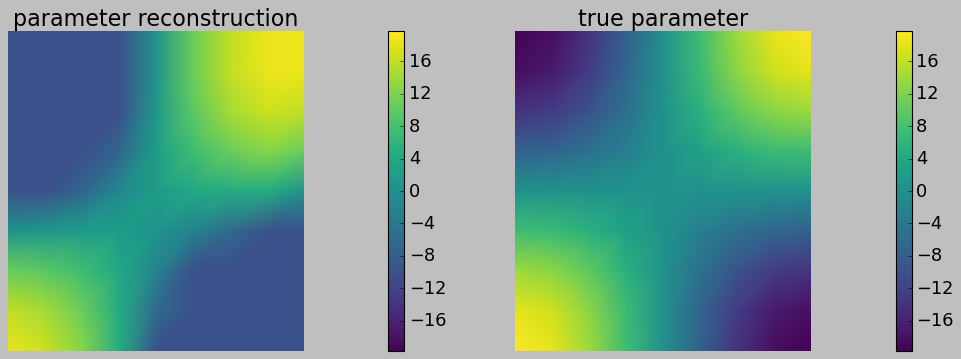

In [11]:
nb.multi1_plot([rhoReconstruction, rhotrue], ["parameter reconstruction", "true parameter"])
plt.show()

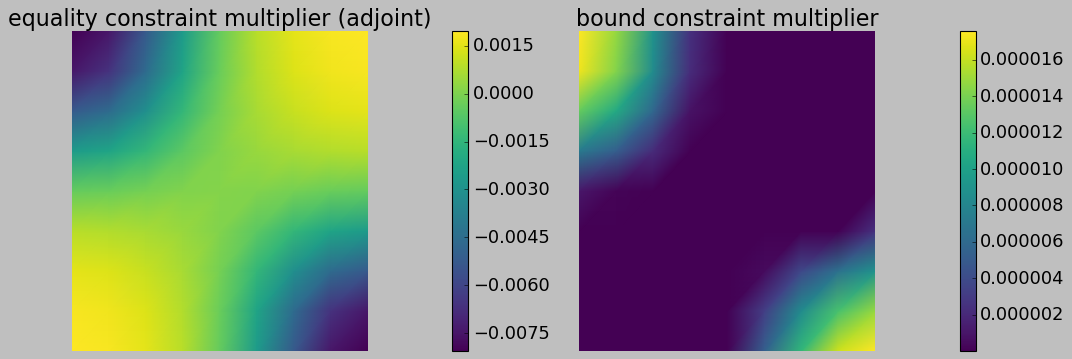

In [12]:
nb.multi1_plot([lamReconstruction, zReconstruction], \
            ["equality constraint multiplier (adjoint)", "bound constraint multiplier"],\
            same_colorbar=False)
plt.show()

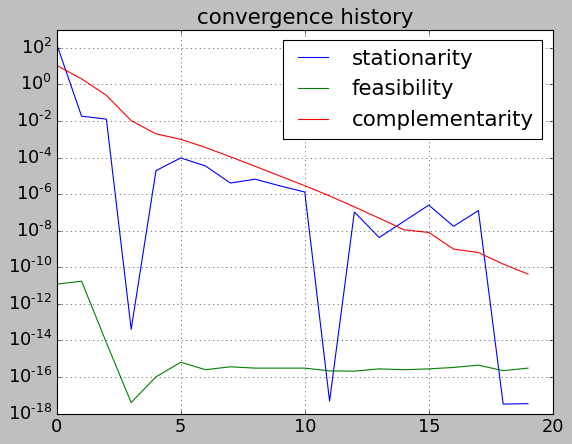

In [13]:
Es = [[E[i][j] for i in range(len(E))] for j in range(len(E[0]))]
labels = ["optimality error", "stationarity", "feasibility", "complementarity"]

for i in range(1,4):
    plt.plot(Es[i], label=labels[i])
    plt.yscale('log')
plt.legend()
plt.grid()
plt.title('convergence history')
plt.show()

In [14]:
mu = Mus[-1]
Ak, Jk, drk = solver.formH(Xf, mu)
#Jk = problem.Dxc(Xf[0])
condAk = np.linalg.cond(Ak)
print("cond(Ak) = {0:1.2e}".format(condAk))
print("cond(Wk) = {0:1.2e}".format(np.linalg.cond(Ak[:problem.n, :problem.n])))

cond(Ak) = 1.19e+08
cond(Wk) = 1.19e+08


In [15]:
Wkinv = np.linalg.inv(Ak[:problem.n,:problem.n])
condJJT = np.linalg.cond(Jk.dot(Jk.T))
condJWkinvJT = np.linalg.cond(Jk.dot(Wkinv).dot(Jk.T))
print("cond(J JT) = {0:1.2e}".format(condJJT))
print("cond(J Wk^-1 J^T) = {0:1.2e}".format(condJWkinvJT))

cond(J JT) = 1.86e+06
cond(J Wk^-1 J^T) = 1.66e+03


In [16]:
Hk = problem.Dxxf(Xf[0])
A  = np.zeros((problem.n+problem.m, problem.n+problem.m))
A[:problem.n,:problem.n] = Hk[:,:]
A[problem.n:,:problem.n] = Jk[:,:]
A[:problem.n,problem.n:] = (Jk.T)[:,:]
condA = np.linalg.cond(A)
print("cond(A) = {0:1.2e}".format(condA))

cond(A) = 2.97e+07


In [ ]:
utest, rhotest = dl.